In [1]:
import pandas as pd
import numpy as np
import requests
import os
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

import torch

In [3]:
dataset = Path("/kaggle/input/almassiradamdataset/kaggle/working/AlMassiraDamDataset")
all_annotations_2023 = Path("/kaggle/input/allmasks/PureMasks/2023")
all_annotations_2024 = Path("/kaggle/input/allmasks/PureMasks/2024")

In [4]:
import cv2
import torch

gt_data = {}

for day in all_annotations_2024.glob("*"):
    gt_data[day.stem] = torch.tensor(cv2.imread(str(day)))    


gt_data['16_03_2024']= torch.tensor(cv2.imread("/kaggle/input/traindata16032024/SegmentationClass/16_03_2024.png"))

In [5]:
for day in all_annotations_2023.glob("*"):
    gt_data[day.stem] = torch.tensor(cv2.imread(str(day)))

In [6]:
all_days = {}
for elm in dataset.glob("*"):    
    tmp = []
    for band in elm.joinpath('cropped').glob("*"):                
        tmp.append(torch.load(str(band)))    
    all_days[elm.name] = (tmp,torch.load(str(elm)+"/fullbands_"+elm.name+".pt"),torch.load(str(elm)+"/tci_"+elm.name+".pt"))        

In [7]:
not_annotated = {}

for elm in all_days:
    if elm not in list(gt_data.keys()):
        not_annotated[elm] = all_days[elm]

for elm in not_annotated:
    del all_days[elm]
        

In [8]:
len(list(all_days))

55

In [9]:
import random
Days_For_Testing = {}
test_days = random.sample(list(all_days.keys()), 5)

for day in test_days:
    Days_For_Testing[day] = all_days[day]
    del all_days[day]


In [10]:
list(Days_For_Testing.keys())

['31_03_2024', '11_01_2024', '28_09_2023', '08_09_2023', '24_08_2023']

In [11]:
import random

#Water (1): 64,246,176
#background (0): 0,0,0

colors = {
 0  :(0, 0, 0),
 1: (64,246,176)
}

In [12]:
def getSpectralTensor(x,y,im):
    """
    x: abscissa of the pixel of interest
    y: ordinate of the pixel of interest
    im: the image in torch form ; (C,W,H)    

    Returns the spectral vector of the pixel of interest i.e. The values of the pixel in each band of the multispectral image
    """

    return im[:,x,y].type(torch.float)

In [13]:
def getPatches(x,y,im,plen):
    
    """
    x: abscissa of the pixel of interest
    y: ordinate of the pixel of interest
    im: the image in torch form ; (C,W,H)
    plen: lenght of the patch

    Extracts a pixel of interest- centred patch with 0 padding in the edge cases.
    """
        
    center = plen//2
    p = torch.zeros((im.shape[0],plen,plen))

    p[:,center,center] = im[:,x,y]

    lineStart = x - (plen-1)//2
    lineEnd = lineStart + (plen-1)

    columnStart = y - (plen-1)//2
    columnEnd = columnStart + (plen-1)
    
    imLines, imCols = im.shape[1],im.shape[2]
    
        
    if (lineStart >= 0 and lineEnd< imLines ) and  \
       (columnStart>= 0 and columnEnd < imCols):
        return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)

    
    if lineStart < 0 and columnStart <0:             
#         print(f"here1| lineStart: {lineStart} | columnStart: {columnStart}")    
        if lineEnd>=imLines and columnEnd >=imCols:     
#             print(f"here1.1| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):plen-(lineEnd-(imLines-1)),abs(columnStart):plen-(columnEnd-(imCols-1))] = im[:,0:lineEnd+1,0:columnEnd+1]        
            
        elif lineEnd>=imLines and columnEnd < imCols:
#             print(f"here1.2| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):plen-(lineEnd-(imLines-1)),abs(columnStart):] = im[:,0:lineEnd+1,0:columnEnd+1]
            
        elif lineEnd<imLines and columnEnd >= imCols:
#             print(f"here1.3| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):,abs(columnStart):plen-(columnEnd-(imCols-1))] = im[:,0:lineEnd+1,0:columnEnd+1]
            
        else:
#             print(f"here1.4| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):,abs(columnStart):] = im[:,0:lineEnd+1,0:columnEnd+1]
            
            

    elif lineStart < 0 and columnStart >= 0:    
#         print(f"here2| lineStart: {lineStart} | columnStart: {columnStart}")    
        if lineEnd>=imLines and columnEnd >=imCols:     
#             print(f"here2.1| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):plen-(lineEnd-(imLines-1)),0:plen-(columnEnd-(imCols-1))] = im[:,0:lineEnd+1,columnStart:columnEnd+1]
            
        elif lineEnd>=imLines and columnEnd < imCols:        
#             print(f"here2.2| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):plen-(lineEnd-(imLines-1)),0:] = im[:,0:lineEnd+1,columnStart:columnEnd+1]
            
        elif lineEnd<imLines and columnEnd >= imCols:
#             print(f"here2.3| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):,0:plen-(columnEnd-(imCols-1))] = im[:,0:lineEnd+1,columnStart:columnEnd+1]
            
        else:
#             print(f"here2.4| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):,0:] = im[:,0:lineEnd+1,columnStart:columnEnd+1]
            


    elif lineStart >= 0 and columnStart < 0:
#         print(f"here3| lineStart: {lineStart} | columnStart: {columnStart}")    
        if lineEnd>=imLines and columnEnd >=imCols:
#             print(f"here3.1| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:plen-(lineEnd-(imLines-1)),abs(columnStart):plen-(columnEnd-(imCols-1))] = im[:,lineStart:lineEnd+1,0:columnEnd+1]
            
        elif lineEnd>=imLines and columnEnd < imCols:
#             print(f"here3.2| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:plen-(lineEnd-(imLines-1)),abs(columnStart):] = im[:,lineStart:lineEnd+1,0:columnEnd+1]
            
        elif lineEnd<imLines and columnEnd >= imCols:
#             print(f"here3.3| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:,abs(columnStart):plen-(columnEnd-(imCols-1))] = im[:,lineStart:lineEnd+1,0:columnEnd+1]
            
        else:
#             print(f"here3.4| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:,abs(columnStart):] = im[:,lineStart:lineEnd+1,0:columnEnd+1]
            
            
            
    else:
#         print(f"here4| lineStart: {lineStart} | columnStart: {columnStart}")    
        if lineEnd>=imLines and columnEnd >=imCols:
#             print(f"here4.1| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:plen-(lineEnd-(imLines-1)),0:plen-(columnEnd-(imCols-1))] = im[:,lineStart:lineEnd+1,columnStart:columnEnd+1]
            
        elif lineEnd>=imLines and columnEnd < imCols:
#             print(f"here4.2| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:plen-(lineEnd-(imLines-1)),:] = im[:,lineStart:lineEnd+1,columnStart:columnEnd+1]
            
        elif lineEnd<imLines and columnEnd >= imCols:
#             print(f"here4.3| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:,0:plen-(columnEnd-(imCols-1))] = im[:,lineStart:lineEnd+1,columnStart:columnEnd+1]
            
        else:
#             print(f"here4.4| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:,0:] = im[:,lineStart:lineEnd+1,columnStart:columnEnd+1]
            
#     plt.imshow(p.permute(1,2,0))
    return p

In [15]:
import torch.nn as nn

class MSIClassSpecSpat(nn.Module):
    
    
    def __init__(self, in_channels):
        super().__init__()
        
        #spectral
        self.Conv1d_1 = nn.Conv1d(1,20,3)
        self.Conv1d_2 = nn.Conv1d(20,9,3)
        self.MaxPool1d = nn.MaxPool1d(3)
        
        
        # spatial
        
        self.Conv2d_1 = nn.Conv2d(in_channels, 30,(3,3))
        self.Conv2d_2 = nn.Conv2d(30, 4,(3,3))        
        self.MaxPool2d = nn.MaxPool2d((2,2))

#         self.relu =  nn.ReLU()
#         self.dropout = nn.Dropout()
        # FC
        
        
        self.FC1 = nn.Linear(43,256)
        self.FC2 = nn.Linear(256,100)
        self.FC3 = nn.Linear(100,1)

        
        #self.softmax = nn.Softmax()
        
        #self.output_activation = nn.Sigmoid()
        
    
    def forward(self,sT,p):
#         sT = getSpectralTensor(x,y,self.image)        
#         p = makeAPatch(x,y,self.image,21)        
        
#         rSpectral = self.Conv1d_2(self.MaxPool1d(self.Conv1d_1(sT.reshape(1,204))))
        
#         rSpatial = self.Conv2d_2(self.MaxPool2d(self.Conv2d_1(torch.permute(p,(2,0,1)).to(device))))
#         SpatialSpectral = torch.concat((rSpectral.flatten(), rSpatial.flatten()))
        
        #return self.FC2(self.FC1(SpatialSpectral))
        
        
    
        return self.FC3(
                    self.FC2(
                        self.FC1(
                            torch.concat(
                                           ( 
                                               torch.flatten(
                                                               self.Conv1d_2(self.MaxPool1d(self.Conv1d_1(sT.unsqueeze(dim=1))))
                                               
                                                      
                           , start_dim=1)
                       , 
                    torch.flatten(
                            self.Conv2d_2(self.MaxPool2d(self.Conv2d_1(p)))
                        ,start_dim=1)), 
                                dim=1)
                )))
        

In [16]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
# Image classification dataa augmentation
#source: https://pytorch.org/vision/stable/transforms.html
import torch
from torchvision.transforms import v2



transforms = v2.Compose([    
    v2.RandomHorizontalFlip(p=0.5),    
    v2.Normalize(mean=[0.485 for _ in range(17)], std=[0.229 for _ in range(17)]),
])


In [18]:
from torch.utils.data import Dataset

class salinasDataset(Dataset):
    def __init__(self, train_data, full_bands_dict):
        self.train = train_data
        self.full_bands_dict = full_bands_dict
#         for elm in self.full_bands_dict:
#             self.full_bands_dict[elm] = torch.tensor(self.full_bands_dict[elm].astype(np.uint8)).permute(2,0,1).type(torch.float)
#         self.image = normalize(self.image)
        
        self.data = []
        
        for x,y,c,elm in self.train:
            self.data.append((getSpectralTensor(x,y,self.full_bands_dict[elm]),getPatches(x,y,self.full_bands_dict[elm],11), c))
        
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,x):
        #return self.data[x] #no augmentation
        return self.data[x][0], transforms(self.data[x][1]), self.data[x][2] #augmentation


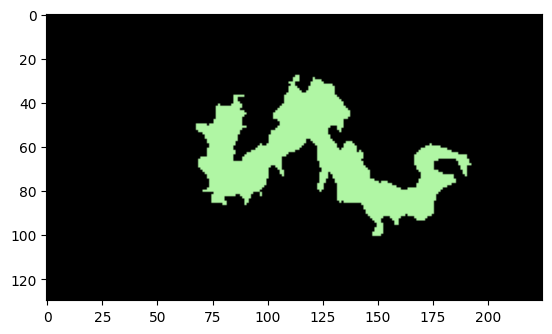

In [19]:
plt.imshow(gt_data[list(gt_data.keys())[0]])

In [20]:
gt_Days_For_Testing = {}

for day in Days_For_Testing:
    gt_Days_For_Testing[day] = gt_data[day]
    del gt_data[day]

In [21]:
for elm in gt_data:
    gt_data[elm] = gt_data[elm][:,:,0]
print(gt_data[elm].unique())

for elm in gt_Days_For_Testing:
    gt_Days_For_Testing[elm] = gt_Days_For_Testing[elm][:,:,0]
print(gt_Days_For_Testing[elm].unique())

tensor([  0, 176], dtype=torch.uint8)
tensor([  0, 176], dtype=torch.uint8)


In [22]:
#Water (1): 64,246,176
#background (0): 0,0,0

for elm in gt_data:
    gt_data[elm][gt_data[elm] == 176] = 1
print(gt_data[elm].unique())

for elm in gt_Days_For_Testing:
    gt_Days_For_Testing[elm][gt_Days_For_Testing[elm] == 176] = 1

print(gt_Days_For_Testing[elm].unique())
    


        

tensor([0, 1], dtype=torch.uint8)
tensor([0, 1], dtype=torch.uint8)


In [23]:
len(gt_data), len(gt_Days_For_Testing)

(50, 5)

In [24]:
train = []
for elm in gt_data:
    for i in range(gt_data[elm].shape[0]):
        for j in range(gt_data[elm].shape[1]):
            train.append((i,j,gt_data[elm][i,j],elm))

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
train, test = train_test_split(train, test_size=0.1)

In [27]:
train, val = train_test_split(train, test_size=0.2)

In [28]:
len(train) + len(val) +len(test), len(train), len(val), len(test)

(1462500, 1053000, 263250, 146250)

In [40]:
# number of pixels of class 0 in train, of class 1
sum([1 for t in train if t[2] == 0]), sum([1 for t in train if t[2] == 1]) 

(934488, 118512)

In [41]:
# number of pixels of class 0 in test, of class 1
sum([1 for t in test if t[2] == 0]), sum([1 for t in test if t[2] == 1]) 

(129852, 16398)

In [42]:
# number of pixels of class 0 in val, of class 1
sum([1 for t in val if t[2] == 0]), sum([1 for t in val if t[2] == 1]) 

(233625, 29625)

In [30]:
test[0],train[0],val[0]

((112, 163, tensor(0, dtype=torch.uint8), '05_04_2024'),
 (9, 104, tensor(0, dtype=torch.uint8), '04_08_2023'),
 (80, 36, tensor(0, dtype=torch.uint8), '21_01_2024'))

In [44]:
full_bands_dict = {}
for elm in all_days:
    full_bands_dict[elm] = all_days[elm][1] #full_bands_dict_2023[elm]
    

In [45]:
import gc
gc.collect()

24866

In [46]:
for elm in full_bands_dict:
    full_bands_dict[elm] = torch.tensor(full_bands_dict[elm].astype(np.uint8)).permute(2,0,1).type(torch.float)

In [47]:
training_data = salinasDataset(train, full_bands_dict)
testing_data = salinasDataset(test, full_bands_dict)
validation_data = salinasDataset(val, full_bands_dict)

/tmp/ipykernel_34/1936903673.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)


In [48]:
from torch.utils.data import DataLoader

train_data_loader = DataLoader(training_data, 16, shuffle=True)
test_data_loader = DataLoader(testing_data, 16)
val_data_loader = DataLoader(validation_data, 16, shuffle=True)

In [49]:
model = MSIClassSpecSpat(17).to(device)

In [50]:
model

MSIClassSpecSpat(
  (Conv1d_1): Conv1d(1, 20, kernel_size=(3,), stride=(1,))
  (Conv1d_2): Conv1d(20, 9, kernel_size=(3,), stride=(1,))
  (MaxPool1d): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_1): Conv2d(17, 30, kernel_size=(3, 3), stride=(1, 1))
  (Conv2d_2): Conv2d(30, 4, kernel_size=(3, 3), stride=(1, 1))
  (MaxPool2d): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (FC1): Linear(in_features=43, out_features=256, bias=True)
  (FC2): Linear(in_features=256, out_features=100, bias=True)
  (FC3): Linear(in_features=100, out_features=1, bias=True)
)

In [51]:
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.0001)

In [54]:
# Adapted from: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score


def train_one_epoch(epoch_index):
    running_loss = 0.
    running_accuracy = 0.
    running_f1 = 0.
    running_precision = 0.
    running_recall = 0.
    
    last_loss = 0.
    last_precision = 0.
    last_f1 = 0.
    last_recall = 0.
    last_accuracy = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_data_loader):
        # Every data instance is an input + label pair
        sTs, ps, labels = data
        sTs = sTs.to(device)
        ps = ps.to(device)
        labels = labels.type(torch.float).to(device)
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(sTs,ps).squeeze() 
        pred_probs = torch.sigmoid(outputs)
        preds = torch.round(pred_probs)
        
        # Derive classes
        
#         yprime = torch.argmax(torch.nn.functional.softmax(outputs, dim=1), dim=1)
        
        # Compute the loss and its gradients
#         loss = loss_fn(outputs, labels)
        loss = loss_fn(outputs, labels)
    
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
#         running_accuracy += accuracy_score(labels.cpu(), yprime.cpu())
        running_accuracy += accuracy_score(labels.cpu(), preds.detach().cpu())    
        running_f1 += f1_score(labels.cpu(), preds.detach().cpu())
        running_precision += precision_score(labels.cpu(), preds.detach().cpu())
        running_recall += recall_score(labels.cpu(), preds.detach().cpu())
        if i % 20000 == 0:
            last_loss = running_loss / 20000 # loss per batch
            last_accuracy = running_accuracy / 20000 # accuracy per batch
            last_f1 = running_f1 / 20000 # accuracy per batch
            last_recall = running_recall / 20000 # accuracy per batch
            last_precision = running_precision / 20000 # accuracy per batch
            print('  batch {} loss: {} accuracy: {} f1: {} precision: {} recall: {} '.format(i + 1, last_loss,last_accuracy,last_f1,last_precision,last_recall))            
            running_loss = 0.
            running_accuracy = 0.
            running_f1 = 0.
            running_precision = 0.
            running_recall = 0.
    
 
    return last_loss, last_accuracy,last_f1,last_recall,last_precision

In [53]:
import warnings
warnings.filterwarnings('ignore')  

In [55]:
epochs = 4

training_loss = []
training_accuracy = []
training_f1 = []
training_recall = []
training_precision = []

#last_loss, last_accuracy,last_f1,last_recall,last_precision

for e in range(epochs):    
    model.train()
    avrg_loss, avrg_accuracy, avrg_f1, avrg_recall, avrg_precision = train_one_epoch(e)
    training_loss.append(avrg_loss)
    training_accuracy.append(avrg_accuracy)
    training_f1.append(avrg_f1)
    training_recall.append(avrg_recall)
    training_precision.append(avrg_precision)
    
    print(f"Epoch {e} avrg_loss {avrg_loss} , avrg_accuracy {avrg_accuracy}, avrg_f1 {avrg_f1}, avrg_recall {avrg_recall}, avrg_precision {avrg_precision}")
    # validation
    eval_accuracy = 0.
    eval_f1 = 0.
    cpt = 0
    with torch.no_grad():        
        model.eval()        
        for i, dataa in enumerate(val_data_loader):
            # Every data instance is an input + label pair
            sTs, ps, labels = dataa
            sTs = sTs.to(device)
            ps = ps.to(device)
            labels = labels.type(torch.float).to(device)

            outputs = model(sTs,ps).squeeze() 
            pred_probs = torch.sigmoid(outputs)
            preds = torch.round(pred_probs)
            eval_accuracy += accuracy_score(labels.cpu(), preds.detach().cpu())
            eval_f1 += f1_score(labels.cpu(), preds.detach().cpu())
            cpt += 1
    
        print(f"Evaluation accuracy: {eval_accuracy/cpt} Evaluation f1 score: {eval_f1/cpt}")
        
                

  batch 1 loss: 3.3766843378543852e-06 accuracy: 4.6875e-05 f1: 0.0 precision: 0.0 recall: 0.0 
  batch 20001 loss: 0.08438741477049147 accuracy: 0.97088125 f1: 0.7161974167498847 precision: 0.7457664880952313 recall: 0.7189603571428491 
  batch 40001 loss: 0.0627698679835632 accuracy: 0.97770625 f1: 0.7508721445221092 precision: 0.7743822023809437 recall: 0.752981547619039 
  batch 60001 loss: 0.05938844225238681 accuracy: 0.978509375 f1: 0.7530045826395481 precision: 0.7752215476190394 recall: 0.7552754166666585 
Epoch 0 avrg_loss 0.05938844225238681 , avrg_accuracy 0.978509375, avrg_f1 0.7530045826395481, avrg_recall 0.7552754166666585, avrg_precision 0.7752215476190394
Evaluation accuracy: 0.9794312933025404 Evaluation f1 score: 0.7535170586540852
  batch 1 loss: 1.2318035587668418e-06 accuracy: 5e-05 f1: 5e-05 precision: 5e-05 recall: 5e-05 
  batch 20001 loss: 0.05706879399589543 accuracy: 0.979578125 f1: 0.7561013367188028 precision: 0.7770254166666603 recall: 0.7583726190476086

**All cases**

In [56]:
test_accuracy = 0.
test_f1 = 0.
test_precision = 0.
test_recall = 0.
cpt=0
with torch.no_grad():        
    
    model.eval()        
    for i, dataa in enumerate(test_data_loader):
        # Every data instance is an input + label pair
        sTs, ps, labels = dataa
        sTs = sTs.to(device)
        ps = ps.to(device)
        labels = labels.type(torch.float).to(device)

        outputs = model(sTs,ps).squeeze() 
        pred_probs = torch.sigmoid(outputs)
        preds = torch.round(pred_probs)
        test_accuracy += accuracy_score(labels.cpu(), preds.detach().cpu())
        test_f1 += f1_score(labels.cpu(), preds.detach().cpu())
        test_precision += precision_score(labels.cpu(), preds.detach().cpu())
        test_recall += recall_score(labels.cpu(), preds.detach().cpu())
        cpt += 1

    print(f"test accuracy: {test_accuracy/cpt}")
    print(f"test f1_score: {test_f1/cpt}")
    print(f"test prescision: {test_precision/cpt}")
    print(f"test recall: {test_recall/cpt}")

test accuracy: 0.981908434525763
test f1_score: 0.7646314946282274
test prescision: 0.7831187064039081
test recall: 0.7660415396877537


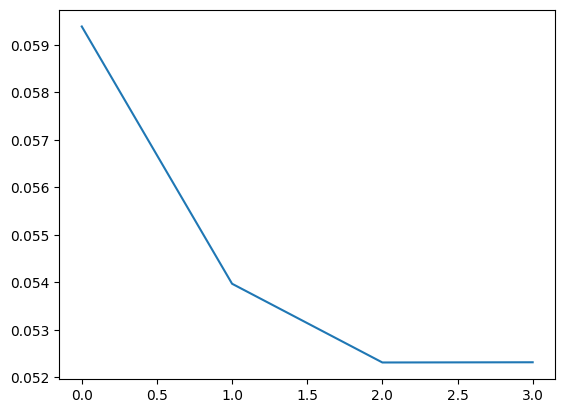

In [57]:
# Training loss curve
plt.plot([i for i in range(len(training_loss[:]))], training_loss[:])

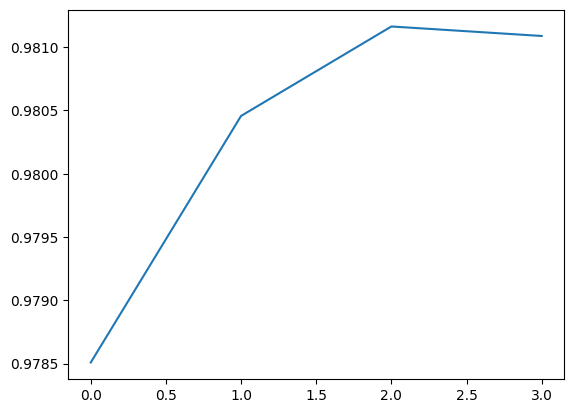

In [58]:
# Training Accuracy curve
plt.plot([i for i in range(len(training_accuracy[:]))], training_accuracy[:])

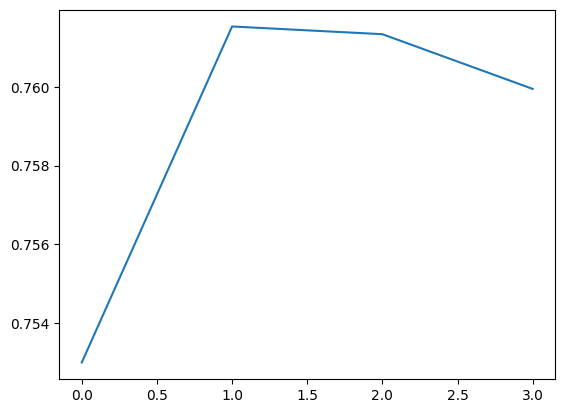

In [59]:
# Training Accuracy curve
plt.plot([i for i in range(len(training_f1[:]))], training_f1[:])

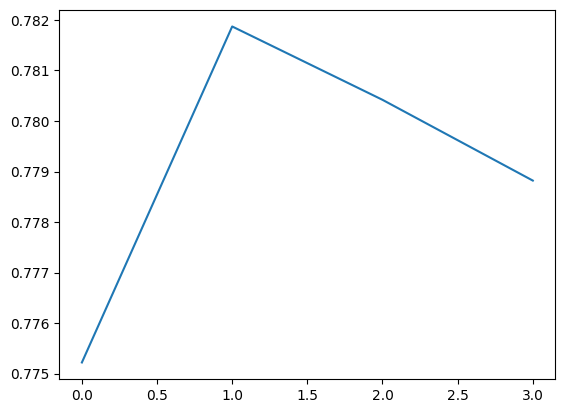

In [60]:
# Training Accuracy curve
plt.plot([i for i in range(len(training_precision[:]))], training_precision[:])

In [61]:
torch.save(model.state_dict(), "dam_water_model.cpt")

In [62]:
def segment_image(all_days,day):
    cropped_bands, full_bands, tci = all_days[day][0],all_days[day][1],all_days[day][2] #prepare_cropped_multiband(all_days, day)
    
    data = torch.tensor(full_bands.astype(np.uint8))
    
    if day in list(gt_data.keys()):
        gt = gt_data[day]      
    elif day in list(gt_Days_For_Testing.keys()):
        gt = gt_Days_For_Testing[day]              
    else:
        gt = torch.zeros_like(data[:,:,0])
    
    im = torch.zeros_like(data)
    the_image_permuted = data.permute(2,0,1)
    
    with torch.inference_mode():
        for x in range(data.shape[0]):        
            for y in range(data.shape[1]):              
                st = getSpectralTensor(x,y,the_image_permuted).unsqueeze(dim=0)
                p = getPatches(x,y,the_image_permuted,11).unsqueeze(dim=0)
                
                
                
                logits = model(st.to(device),p.to(device))
            
                yprime = torch.round(torch.sigmoid(logits))
                
#                 print(torch.sigmoid(logits))
                
                im[x,y,0:3] = yprime
                
#                 logits = model(st.to(device),p.to(device))                
#                 yprime = torch.argmax(torch.nn.functional.softmax(logits))

#                 im[x,y,0:3] = yprime
    
    
    im_gray = torch.clone(im[:,:,0])
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            im[i,j,0:3] = torch.tensor(colors[im[i,j,0].item()])        
    
    plt.figure(figsize=(12,10))
    plt.subplot(1,3,1)
    plt.imshow(im_gray, cmap="Accent")
    plt.title("segmentation")
    
    plt.subplot(1,3,2)
    plt.imshow(tci)
    plt.title("TCI")
    
    
    plt.subplot(1,3,3)
    plt.imshow(gt, cmap="Accent")
    plt.title("GroundTruth")
    
    
    


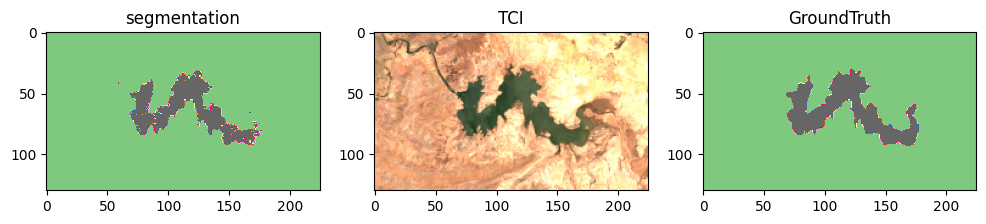

In [63]:
segment_image(all_days, "25_04_2024")

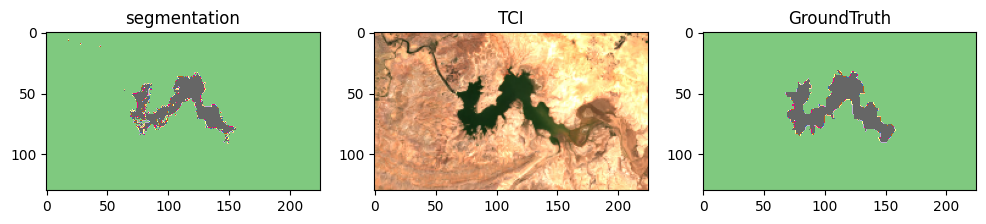

In [64]:
segment_image(all_days, "16_03_2024")

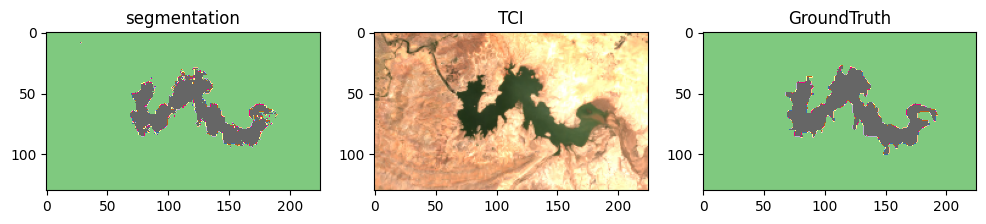

In [65]:
segment_image(all_days, "05_04_2024")

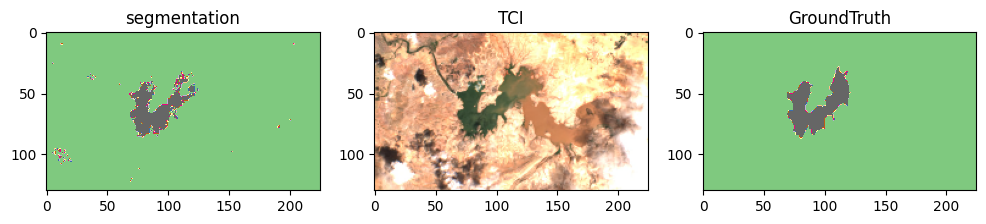

In [67]:
segment_image(Days_For_Testing, list(Days_For_Testing.keys())[0])

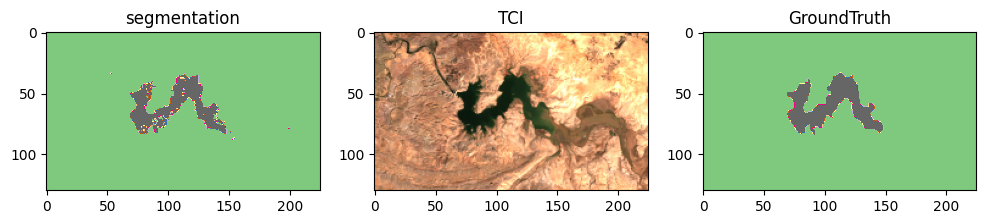

In [68]:
segment_image(Days_For_Testing, list(Days_For_Testing.keys())[1])

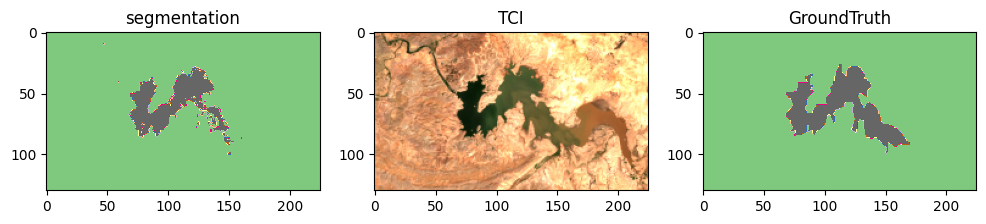

In [69]:
segment_image(Days_For_Testing, list(Days_For_Testing.keys())[2])

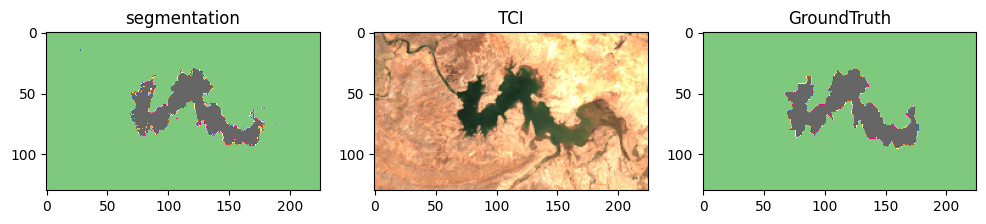

In [70]:
segment_image(Days_For_Testing, list(Days_For_Testing.keys())[3])

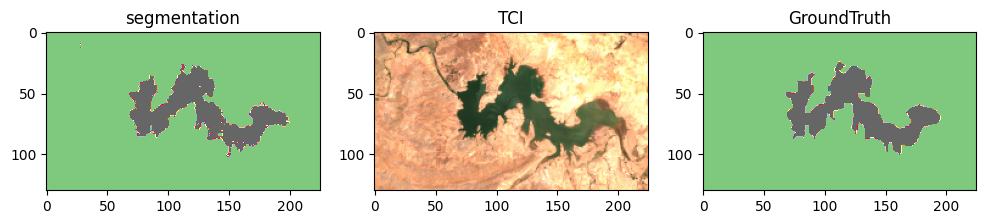

In [71]:
segment_image(Days_For_Testing, list(Days_For_Testing.keys())[4])